## Coal Retirements

Data provided by the EIA

Retirements from 2012 to most recently available - Aug 2018

In [22]:
import pandas as pd
import requests
import zipfile
import io
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [23]:
coal_retirements = pd.read_csv('data/coal_retirements_since_2012_as_of_2018_08.csv')
coal_retirements.head()

,Entity ID,Entity Name,Plant ID,Plant Name,Sector,Plant State,Generator ID,Unit Code,Nameplate Capacity (MW),Net Summer Capacity (MW),...,Energy Source Code,Prime Mover Code,Retirement Month,Retirement Year,Operating Month,Operating Year,County,Latitude,Longitude,Balancing Authority Code
0,13756,Northern Indiana Pub Serv Co,995,Bailly,Electric Utility,IN,7,NaN,190.4,160.0,...,BIT,ST,6,2018,11,1962,Porter,41.645000,-87.12250,MISO
1,13756,Northern Indiana Pub Serv Co,995,Bailly,Electric Utility,IN,8,NaN,413.1,320.0,...,BIT,ST,6,2018,7,1968,Porter,41.645000,-87.12250,MISO
2,60415,"CP Crane Power, LLC",1552,"CP Crane Power, LLC",IPP Non-CHP,MD,1,NaN,190.4,190.0,...,SUB,ST,6,2018,7,1961,Baltimore,39.323604,-76.36512,PJM
3,60415,"CP Crane Power, LLC",1552,"CP Crane Power, LLC",IPP Non-CHP,MD,2,NaN,209.4,195.0,...,SUB,ST,6,2018,2,1963,Baltimore,39.323604,-76.36512,PJM
4,4922,Dayton Power & Light Co,2850,J M Stuart,Electric Utility,OH,2,NaN,610.2,577.0,...,BIT,ST,6,2018,10,1970,Adams,38.636100,-83.69390,PJM


In [24]:
grouped = coal_retirements.groupby('Plant ID').agg({'Nameplate Capacity (MW)': 'sum', 'Plant Name':'first', 'Generator ID': 'count', 'Latitude': 'first', 'Longitude': 'first'})
grouped = grouped.rename(index=str, columns={'Nameplate Capacity (MW)': 'Nameplate_capacity_mw', 'Generator ID': 'Number_of_generators'})
grouped.head()

,Nameplate_capacity_mw,Plant Name,Number_of_generators,Latitude,Longitude
Plant ID,,,,,
3,272.0,Barry,1,31.006900,-88.01030
8,250.0,Gorgas,2,33.644344,-87.19649
47,1350.0,Colbert,5,34.743900,-87.84860
50,1968.6,Widows Creek,8,34.883022,-85.75525
113,288.9,Cholla,1,34.939400,-110.30330


In [25]:
grouped.Nameplate_capacity_mw.sum()

66809.5

## Matplotlib Approach

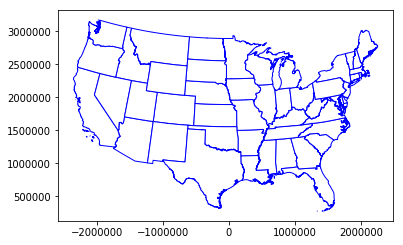

In [27]:
lower48_states = lower48_states.to_crs({'init':'epsg:5071'})
lower48_states.plot(color='white', edgecolor='b')

Done
['cb_2017_us_county_500k.dbf', 'cb_2017_us_county_500k.prj', 'cb_2017_us_county_500k.shp', 'cb_2017_us_county_500k.shx']
Shape of the dataframe: (3233, 10)
Projection of dataframe: {'init': 'epsg:4269'}


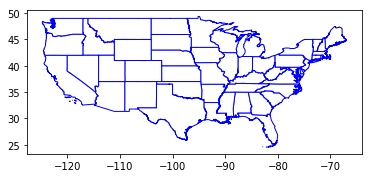

In [9]:
county_file_url = 'http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_county_500k.zip'
print('Downloading shapefile...')
r = requests.get(county_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path='tmp/') # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

dbf, prj, shp, shx = [filename for filename in filenames]
usa = gpd.read_file(f'tmp/{shp}')
print("Shape of the dataframe: {}".format(usa.shape))
print("Projection of dataframe: {}".format(usa.crs))
usa.tail() #last 5 records in dataframe

usa = usa[np.logical_not(usa.STATEFP.isin(['02','15']))] #remove AK, HI
usa.STATEFP = pd.to_numeric(usa.STATEFP)
lower48 = usa.query('STATEFP < 57')

lower48_states = lower48.dissolve(by='STATEFP')
lower48_states.plot(color='white', edgecolor='b')

In [35]:
geometry = [Point(xy) for xy in zip(grouped.Longitude, grouped.Latitude)]

In [36]:
coal_retirements_gdf = gpd.GeoDataFrame(grouped, geometry=geometry)

In [37]:
coal_retirements_gdf.crs = {'init' :'epsg:4326'}

In [38]:
coal_retirements_gdf = coal_retirements_gdf.to_crs({'init' :'epsg:5071'})

In [39]:
coal_retirements_gdf

,Nameplate_capacity_mw,Plant Name,Number_of_generators,Latitude,Longitude,geometry
Plant ID,,,,,,
3,272.0,Barry,1,31.006900,-88.01030,POINT (759769.2812470198 913190.5319579457)
8,250.0,Gorgas,2,33.644344,-87.19649,POINT (809749.6772315506 1212771.082064203)
47,1350.0,Colbert,5,34.743900,-87.84860,POINT (739391.6670219288 1329880.517924268)
50,1968.6,Widows Creek,8,34.883022,-85.75525,POINT (926938.8074685446 1363724.70595751)
113,288.9,Cholla,1,34.939400,-110.30330,POINT (-1290828.286079457 1417344.816529832)
207,1358.0,St Johns River Power Park,2,30.430800,-81.55080,POINT (1380050.114700226 922320.5459748185)
462,43.7,W N Clark,2,38.434400,-105.25000,POINT (-798575.5788823019 1750409.733190187)
465,152.5,Arapahoe,2,39.670000,-105.00280,POINT (-764199.4421022275 1886224.107618121)
469,295.5,Cherokee,2,39.807275,-104.96450,POINT (-759509.1039189132 1901231.337963395)


In [64]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = coal_retirements_gdf.Nameplate_capacity_mw
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=[0] + bounds + [13],
                                extend='both',
                                ticks=bounds,
                                spacing='proportional',
                                orientation='horizontal')

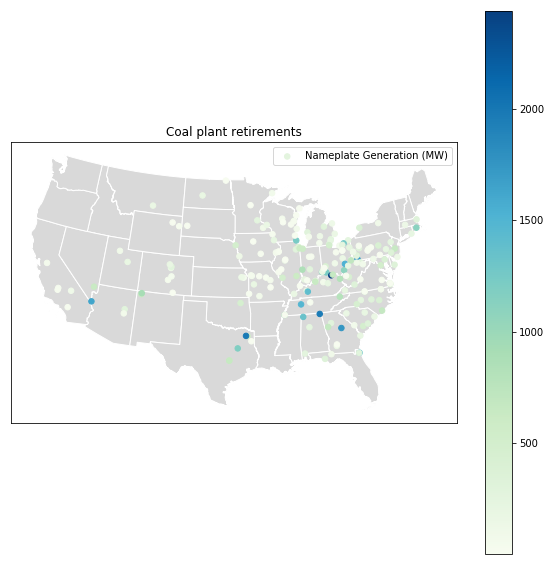

In [66]:
ax = lower48_states.plot(figsize=(10,10),color='#d9d9d9', edgecolor='white')
ax.set(xticks=[], yticks=[]) #removes axes
ax.set_title("Coal plant retirements", fontsize='large')
# We can now plot our GeoDataFrame.
coal_retirements_gdf.plot(ax=ax, column='Nameplate_capacity_mw', markersize = 30, cmap='GnBu', legend=True)
plt.legend(['Nameplate Generation (MW)'], numpoints = 10)
plt.savefig('coal_retirements.svg', pad_inches=0.1, dpi=600)

## Plotly Approach

In [4]:
grouped['Nameplate_capacity_mw'].max()

2440.8

PLotly suggested circle area size `sizeref = 2. * max(array of size values) / (desired maximum marker size ** 2)`

In [19]:
grouped['text'] = grouped['Plant Name'] + '<br> Total Generation ' + grouped['Nameplate_capacity_mw'].round().astype(str)+' MW'
limits = [(0,100),(100,400),(400,1000),(1000,1500),(1500,2000),(2000,2500)]
colors = ['#333333','#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']
scale = 4000
plants = []

In [5]:
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [7]:
init_notebook_mode(connected=True)

In [34]:
len(colors)

6

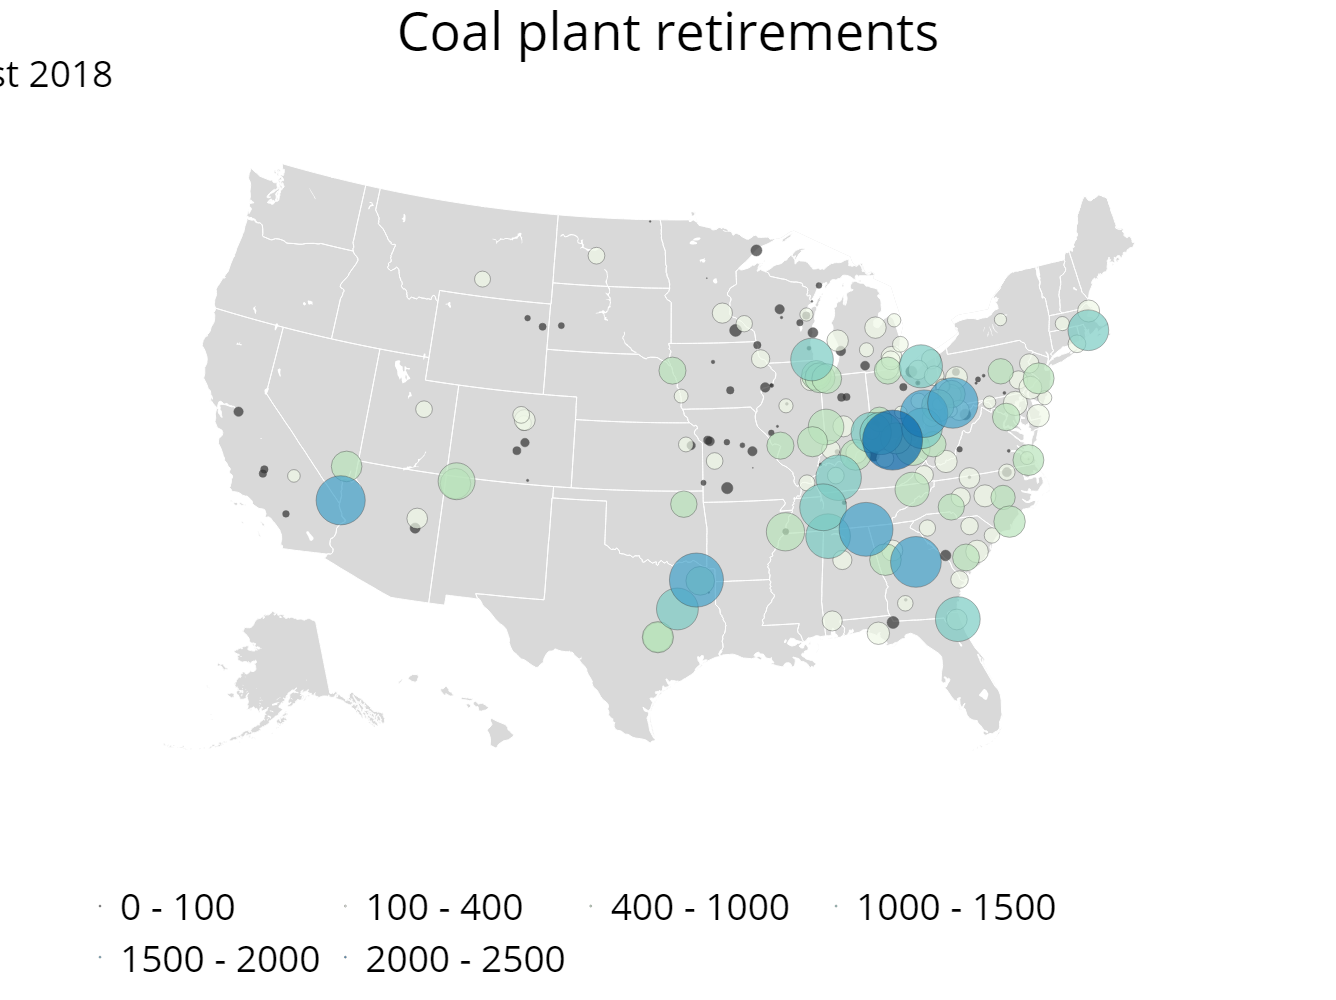

In [20]:
max_mw = grouped['Nameplate_capacity_mw'].max()
fig = []
for i in range(len(limits)):
    lim = limits[i]
    df_sub = grouped.query('Nameplate_capacity_mw > @lim[0] and Nameplate_capacity_mw < @lim[1]')
    plant = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Nameplate_capacity_mw']/scale,
            sizeref = 2. * (max_mw/scale) / (60 ** 2),
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    plants.append(plant)

layout = dict(
        title = 'Coal plant retirements',
        annotations = [
            dict(
            xref= 'paper',
            yref= 'paper',
            align= 'left',
            x=0.03,
            xanchor= 'right',
            y=1,
            yanchor='bottom',
            text= ' January 2012 - August 2018',
            showarrow=False
            )
        ],
        height=1000,
        width=1000,
        showlegend = True,
        legend = dict(orientation='h'),
        font = dict(family = 'Open Sans', size=37, color='black'),
        geo = dict(
            scope='usa',
            resolution = 50,
            projection=dict( type='albers usa' ),
            showland = True,
            showlakes = True,
            showcoastlines = True,
            coastlinecolor = "rgb(255, 255, 255)",
            lakecolor = 'rgb(255, 255, 255)',
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=plants, layout=layout)
iplot(fig)

In [21]:
pio.write_image(fig, 'retirements.svg', width = 1000, height = 1000, scale = 0.36)